In [1]:
from pyomo.environ import *
from pyomo.dae import *
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_model_variable_volume(xss={},uss={},ucon={},xinit = 0.3,uinit=200):
    # The dynamic model is 
    # dc/dt = uin(t) cin - uout(t) c(t) ) / V(t) - 2 * c(t)^3
    # dV/dt = uin(t)-uout(t)
    # c is the concentration, uin, uout are the inlet and outlet flowrate, V the volume, 2 is the reaction constant
    m = ConcreteModel()
    m.t = ContinuousSet(bounds=(0,10))

    m.V = Var(m.t, bounds = (20,100)) # volume
    m.c = Var(m.t, bounds = (0,1))    # concentration
    m.uin = Var(m.t, bounds = (0,800)) # inlet floweate
    m.uout = Var(m.t, bounds = (0,800)) # outlet flowrate

    m.dc = DerivativeVar(m.c, wrt=m.t) # dc/dt
    m.dV = DerivativeVar(m.V, wrt=m.t) # dV/dt
    m.duin = DerivativeVar(m.uin, wrt=m.t, bounds = (None,None)) # duin/dt
    m.duout = DerivativeVar(m.uout, wrt=m.t, bounds = (None,None)) # duout/dt

    m.ode = Constraint(m.t, rule = lambda m,t: m.dc[t]==(m.uin[t]- m.uout[t]*m.c[t])/m.V[t] - 2*m.c[t]**3) 
    m.odeV = Constraint(m.t, rule = lambda m,t: m.dV[t]==m.uin[t] - m.uout[t])

    # discretize differential equations
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m,nfe=50,wrt=m.t,scheme='BACKWARD')

    # m.c[0].fix(xinit)
    # m.u[0].fix(uinit)

    # limits on how fast the flowrates can change
    m.der_u = Constraint(m.t, rule = lambda m,t: m.duin[t] <= 20)
    m.der_l = Constraint(m.t, rule = lambda m,t: m.duin[t] >= -20)

    m.der_u2 = Constraint(m.t, rule = lambda m,t: m.duout[t] <= 20)
    m.der_l2 = Constraint(m.t, rule = lambda m,t: m.duout[t] >= -20)
    

    p = {}
    time_ = [t for t in m.t]
    for t in m.t:
        k_ = list(xss.keys())
        v_ = list(xss.values())
    
        diff = [(t-i)**2 for i in xss.keys()]
        idx = np.argmin(diff)

        p[t] = v_[idx]
        
    def _intX(m,t):
        # return (m.c[t] - xss[math.ceil(t)])**2
        return (m.c[t] - p[t])**2
    m.intX = Integral(m.t,wrt=m.t,rule=_intX)

    def _obj(m):
        return m.intX
    m.obj = Objective(rule=_obj)
    # m.obj = Objective(expr = sum( (m.c[t] - xss[math.ceil(t)])**2 for t in m.t), sense=minimize)
    return m,p
    

In [4]:
import deepxde as dde

/Users/ilias/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [12]:
import random
# generate a random production target
space = dde.data.GRF(T=10, kernel = 'RBF', length_scale=2)
feats = -space.random(1)
xs = np.linspace(0, 10, num=51)[:, None] # - time 
y = 0.5 + 0.1* space.eval_batch(feats, xs) # - production target
xss = {}
for j in range(len(xs)):
    xss[xs[j][0]] = y[0][j]
uss = {}
x0_ = 0.2 #np.random.uniform(0,1,1)[0]
u0 = 250 #np.random.uniform(200,1500,1)[0]
ucon = 100
m,p = get_model_variable_volume(xss,uss,ucon, x0_,u0)


Text(0, 0.5, 'Concentration')

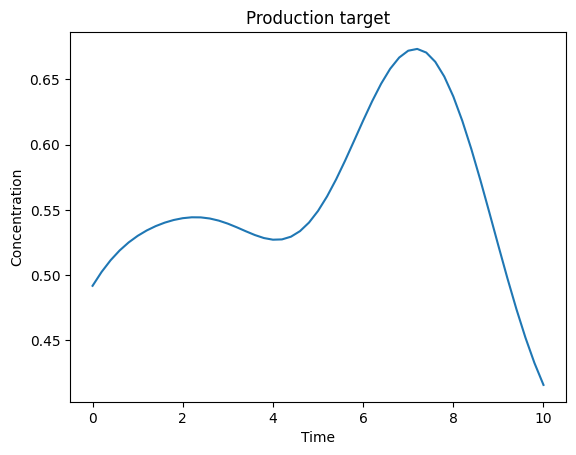

In [19]:
plt.title('Production target')
plt.plot([t for t in m.t], p.values())
plt.xlabel('Time')
plt.ylabel('Concentration')

Solve the model with IPOPT

In [ ]:
solver = SolverFactory('ipopt')
res = solver.solve(m,tee=False)
# store the results
t_ = [t for t in m.t]
V_sol = [m.V[t]() for t in m.t]
uin_sol = [m.uin[t]() for t in m.t]
uout_sol = [m.uout[t]() for t in m.t]
c_sol = [m.c[t]() for t in m.t]

In [ ]:
plt.plot(t_, V_sol)